In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Prepare data

In [3]:
path = Path('data')
path

PosixPath('data')

In [21]:
df = pd.read_csv(path/'clean.csv')
df.head()

,Unnamed: 0,itemid,title,Category,image_path
0,0,307504,beauty nyx sex bomb pallete natural palette,0,beauty_image/6b2e9cbb279ac95703348368aa65da09
1,1,461203,beauty etude house precious mineral any cushio...,1,beauty_image/20450222d857c9571ba8fa23bdedc8c9
2,2,3592295,beauty milani rose powder blush,2,beauty_image/6a5962bed605a3dd6604ca3a4278a4f9
3,3,4460167,beauty etude house baby sweet sugar powder,3,beauty_image/56987ae186e8a8e71fcc5a261ca485da
4,4,5853995,beauty bedak revlon color stay aqua mineral ma...,3,beauty_image/9c6968066ebab57588c2f757a240d8b9


In [5]:
bs = 64

In [6]:
valid_size = 100000
valid_idx = range(len(df)-valid_size, len(df))
valid_idx

range(566615, 666615)

## Language Model

In [7]:
# data_lm = (TextList.from_csv(path, 'train.csv', cols='title')
#             .split_by_idx(valid_idx)
#             .label_for_lm()
#             .databunch(bs=bs))
# data_lm.save('data_lm.pkl')

Load from from previous learning model without having to parse data again

In [8]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [9]:
len(data_lm.vocab.itos)

24183

In [10]:
data_lm.show_batch()

idx,text
0,chafing relief gel xxbos milani rose powder blush tea xxbos the balm meet matte trimony xxbos laneige water base cc cream spf36 pa xxbos giordani gold age defying compact foundation dengan spf 15 perfect cover xxbos the body shop refill moisture white perfect foundation xxbos lancome blush subtil long lasting powder blusher colour veil buildable xxunk xxbos missha line friends magic cushion moisture 2 refills xxbos elf acne fighting foundation
1,23 refill xxbos bh cosmetics dark rose eyeshadow blush and liquid eyeliner xxbos lt pro sc crm fnd yellow xxunk g xxunk xxbos j.cat beauty h20 fresh dewy hydrating face primer xxbos giorgio armani lasting silk uv foundation spf 20 xxbos it cosmetics your skin but better cc cream with spf 50 xxbos etude house fix and powder xxbos theraskin loose powder acne kl bedak tabur jerawat xxbos the balm
2,olay total effects 7 in one night cream 50 g terlaris xxbos new missha perfect cover bb cream spf 42 pa 20ml original free ongkir xxbos promo bedak wardah xxbos bedak ran shade r23 pink powder limited edition xxbos xxunk anti acne bedak wajah terbaik xxbos new skinfood white grape fresh foundation free ongkir xxbos chanel poudre universelle compacte natural finish pressed powder xxbos cream hn original harga 75.000 15gr
3,rimmel stay matte pressed powder creamy beige termurah promo bulan ini xxbos hot sale bioaqua smooth muscle flawless blush on cushion xxbos inez translucent acne care face powder bedak xxbos berkualitas bedak make over perfect cover two way cake xxbos stok terbatas innisfree no sebum mineral powder xxbos compact powder oriflame xxbos murah revlon touch glow moisturizing face powder 24gr bedak tabur xxbos xxunk beauty glazed oil essence primer makeup
4,refill xxbos nivea shave balm primer xxbos the balm mary lou manizer without box xxbos etude house cc cream 8 in 1 multi function xxbos the balm shelter tinted moisturizer xxbos paket theraskin normal cream xxbos maybelline super bb cushion spf29 original xxbos loreal magic skin bb cream xxbos bourjois healthy balance unifying powder xxbos the balm nude dude vol 2 xxbos theraskin acne xxbos bourjois compact powder shade 72


In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02


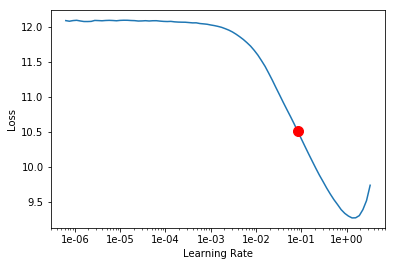

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
lr = 3e-2

In [14]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.547815,3.558373,0.347958


In [16]:
learn.save('fit_head')

In [17]:
learn.load('fit_head');

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(10, lr/10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.207716,3.395104,0.368754
2,3.008576,3.246993,0.382585
3,2.874729,3.160020,0.392553
4,2.746629,3.087144,0.400583
5,2.638892,3.016283,0.409438
6,2.533626,2.966538,0.418686
7,2.427194,2.935354,0.424626
8,2.339073,2.920251,0.428916
9,2.250934,2.920364,0.431405
10,2.202916,2.926761,0.431794


In [20]:
learn.save('fine_tuned')

In [21]:
learn.save_encoder('fine_tuned_enc')

## Classifier

#### Load data

In [22]:
bs = 96

In [23]:
data_clas = (TextList.from_csv(path, 'clean.csv', cols='title', vocab=data_lm.vocab)
            .random_split_by_pct(100000/666615)
            .label_from_df(cols='Category')
            .databunch(bs=bs))
data_clas.save('data_clas.pkl')

In [24]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [25]:
data_clas.show_batch()

text,target
xxbos fashion lanaa brocade blouse 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29,26
xxbos mobile promo hari ini beli 2 gratis 1 samsung galaxy s8 plus ram 4 gb rom 64 gb new ori wa 083137196109,32
xxbos mobile promo khusus hari ini beli 2 gratis 1 samsung galaxy j4 2018 ram 2 gb rom 32 gb garansi resmi sein,31
xxbos mobile promo hari ini beli 2 gratis 1 oppo f5 ram 4 gb rom 64 gb new ori wa 085285720089 cuci gudang,41
xxbos mobile u info silakkan chat kami di wa 083813405656 big promo beli 2 gratis 1 xiaomi mi max gold 4 64,34


In [26]:
len(data_clas.vocab.itos)

24183

In [27]:
data_clas.c, len(data_clas.train_ds), len(data_clas.valid_ds)

(58, 566615, 100000)

#### Load pretrained encoder

In [28]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

#### Start training by unfreezing a few layers each time

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02


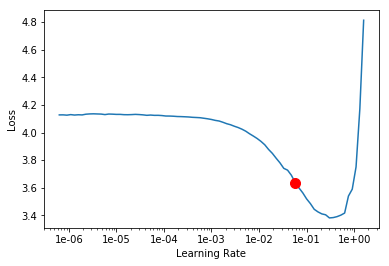

In [29]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.327417,1.097052,0.668700


In [31]:
learn.save('nlp-pref-stage-1')

In [32]:
learn.load('nlp-pref-stage-1');

In [33]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.051767,0.943714,0.709650


In [34]:
learn.save('nlp-pref-stage-2')

In [35]:
learn.load('nlp-pref-stage-2');

In [36]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.938914,0.883444,0.721470


In [37]:
learn.save('nlp-pref-stage-3')

In [38]:
learn.load('nlp-pref-stage-3');

In [39]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.937978,0.867210,0.727060
2,0.913595,0.854047,0.729680


In [41]:
learn.save('nlp-pref-stage-4')

In [42]:
learn.load('nlp-pref-stage-4');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


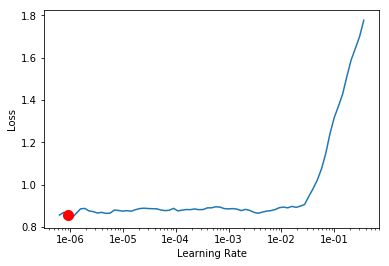

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.891445,0.853772,0.730410
2,0.921898,0.850387,0.731820
3,0.867292,0.834929,0.736060
4,0.884910,0.820255,0.738670
5,0.842699,0.812458,0.742170
6,0.824788,0.803526,0.744310
7,0.830797,0.800242,0.746450
8,0.812795,0.797189,0.747990
9,0.805535,0.793468,0.748150
10,0.782950,0.798484,0.747960


In [45]:
learn.save('nlp-pref-stage-5')

In [46]:
learn.export(fname = 'export_nlp_pref.pkl')

## Test

In [47]:
learn = load_learner(path, fname = 'export_nlp_pref.pkl')

In [48]:
test_df = pd.read_csv(path/'test.csv')
test_df.head()

,itemid,title,image_path
0,370855998,flormar 7 white cream bb spf 30 40ml,beauty_image/1588591395c5a254bab84042005f2a9f.jpg
1,637234604,maybelline clear smooth all in one bb cream sp...,beauty_image/920985ed9587ea20f58686ea74e20f93.jpg
2,690282890,murah innisfree eco natural green tea bb cream...,beauty_image/90b40e5710f54352b243fcfb0f5d1d7f.jpg
3,930913462,loreal white perfect day cream spf 17 pa white...,beauty_image/289c668ef3d70e1d929d602d52d5d78a.jpg
4,1039280071,hada labo cc cream ultimate anti aging spf 35 ...,beauty_image/d5b3e652c5822d2306f4560488ec30c6.jpg


In [51]:
for index, row in test_df.iterrows():
    big_category = row['image_path'].split('/')[0].split('_')[0]
    test_df.iat[index, 1] = big_category + ' ' + row['title']
test_df.head()

,itemid,title,image_path,Category
0,370855998,beauty flormar 7 white cream bb spf 30 40ml,beauty_image/1588591395c5a254bab84042005f2a9f.jpg,0
1,637234604,beauty maybelline clear smooth all in one bb c...,beauty_image/920985ed9587ea20f58686ea74e20f93.jpg,0
2,690282890,beauty murah innisfree eco natural green tea b...,beauty_image/90b40e5710f54352b243fcfb0f5d1d7f.jpg,0
3,930913462,beauty loreal white perfect day cream spf 17 p...,beauty_image/289c668ef3d70e1d929d602d52d5d78a.jpg,0
4,1039280071,beauty hada labo cc cream ultimate anti aging ...,beauty_image/d5b3e652c5822d2306f4560488ec30c6.jpg,0


In [52]:
test_df['Category'] = 0

In [53]:
test_df.head()

,itemid,title,image_path,Category
0,370855998,beauty flormar 7 white cream bb spf 30 40ml,beauty_image/1588591395c5a254bab84042005f2a9f.jpg,0
1,637234604,beauty maybelline clear smooth all in one bb c...,beauty_image/920985ed9587ea20f58686ea74e20f93.jpg,0
2,690282890,beauty murah innisfree eco natural green tea b...,beauty_image/90b40e5710f54352b243fcfb0f5d1d7f.jpg,0
3,930913462,beauty loreal white perfect day cream spf 17 p...,beauty_image/289c668ef3d70e1d929d602d52d5d78a.jpg,0
4,1039280071,beauty hada labo cc cream ultimate anti aging ...,beauty_image/d5b3e652c5822d2306f4560488ec30c6.jpg,0


In [54]:
for index, row in test_df.iterrows():
    test_df.iat[index, 3] = learn.predict(row['title'])[0];

In [55]:
test_df.head()

,itemid,title,image_path,Category
0,370855998,beauty flormar 7 white cream bb spf 30 40ml,beauty_image/1588591395c5a254bab84042005f2a9f.jpg,5
1,637234604,beauty maybelline clear smooth all in one bb c...,beauty_image/920985ed9587ea20f58686ea74e20f93.jpg,5
2,690282890,beauty murah innisfree eco natural green tea b...,beauty_image/90b40e5710f54352b243fcfb0f5d1d7f.jpg,5
3,930913462,beauty loreal white perfect day cream spf 17 p...,beauty_image/289c668ef3d70e1d929d602d52d5d78a.jpg,4
4,1039280071,beauty hada labo cc cream ultimate anti aging ...,beauty_image/d5b3e652c5822d2306f4560488ec30c6.jpg,5


In [56]:
res_df = pd.DataFrame({'itemid':test_df['itemid'], 'Category':test_df['Category']}, columns=['itemid', 'Category'])

In [57]:
res_df.head()

,itemid,Category
0,370855998,5
1,637234604,5
2,690282890,5
3,930913462,4
4,1039280071,5


In [58]:
res_df.to_csv(path/'results_pref.csv', index=False)